<a href="https://colab.research.google.com/github/schwallergroup/ai4chem_course/blob/main/notebooks/08%20-%20Retrosynthesis/template_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 8: Retrosynthetic analysis

So far we in the course we have learnt how Machine Learning can help us classify and predict properties of molecules, how to generate new molecules with desired properties, and finally how to predict the reactivity of a reaction mixture.

Central to the chemists' work is, however, **how to make molecules**, and this is what we will explore in this notebook. To do retrosynthetic analysis, we start from the target molecule and try to decide what transformation would lead to the desired product.

<img src='https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/08%20-%20Retrosynthesis/retro_q.png?raw=1'>

## How do we decide this?

In the simplest approach, we would need to have **a library of all possible transformations**, and then we decide **which transformations will more likely yield our desired product**.

A list of possible transformations are all the name reactions you learn in your organic chemistry course: Grignard Reaction, Diels-Alder Cycloaddition, Aldolic condensation, etc. We then use our **chemical knowledge** to decide which of these can yield the product.

Clearly here, a Grignard reaction makes sense, while a Diels-Alder doesn't.


<img src='https://github.com/schwallergroup/ai4chem_course/blob/main/notebooks/08%20-%20Retrosynthesis/retro_1.png?raw=1'>

Now, how can a model learn this process?


**In this notebook, we will learn how to extract a library of transformations from a reaction dataset, and then train a model to do one-step retrosynthesis.**

# 0. Relevant packages

## RDChiral

RDChiral is a wrapper for RDKit's functionalities for reaction handling, that improves stereochemistry handling. This package will allow us to extract `reaction templates` from a reaction dataset, which are a standard way of encoding **transformation rules**.

RDChiral then also lets us apply the `reaction template` to a target molecule, to discover the reactants that will afford the target molecule under the given transformation.

Learn more from [the code](https://github.com/connorcoley/rdchiral) and [the paper](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00286).

## Download data

We will use a subset of the USPTO reaction dataset containing 50k reactions. This is commonly used to train and test new models for this task in the literature.

In [1]:
! pip install reaction-utils
! pip install scikit-learn==1.2.2
! mkdir data/
! curl -L https://www.dropbox.com/sh/6ideflxcakrak10/AADN-TNZnuGjvwZYiLk7zvwra/schneider50k -o data/uspto50k.zip
! unzip data/uspto50k.zip -d data/
! wget https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/08%20-%20Retrosynthesis/utils.py

mkdir: cannot create directory ‘data/’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   144  100   144    0     0    197      0 --:--:-- --:--:-- --:--:--   197
100    17  100    17    0     0     12      0  0:00:01  0:00:01 --:--:--    12
100 19.0M  100 19.0M    0     0  4626k      0  0:00:04  0:00:04 --:--:-- 7801k
Archive:  data/uspto50k.zip
mapname:  conversion of  failed
replace data/raw_val.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: --2025-08-11 13:35:06--  https://raw.githubusercontent.com/schwallergroup/ai4chem_course/main/notebooks/08%20-%20Retrosynthesis/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4943 (4.8K) 

**Restart runtime!**

In [17]:
from utils import load_data, visualize_chemical_reaction

train_df, val_df, test_df = load_data()

# 1. Reaction templates

Let's take as an example the following coupling reaction.


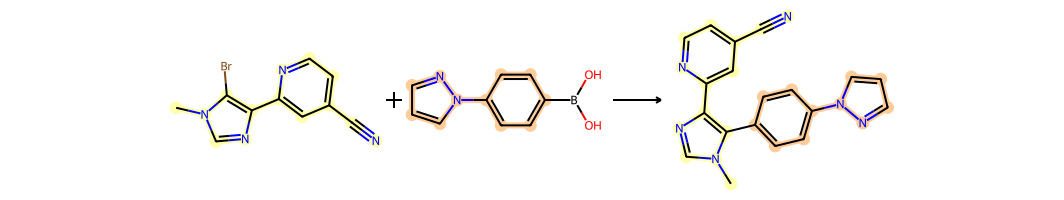

In [3]:
rxn_example = train_df.iloc[5,0]

visualize_chemical_reaction(rxn_example)

### To extract the reaction template, use the `extract_template` function from utils.py

A reaction template describes a general transformation of some type. It describes what bonds form and break in a transformation, as well as the chemical environment of these bonds.

In [4]:
from utils import extract_template

tplt_example = extract_template(rxn_example)

# A reaction template looks like this
print(tplt_example)

Br-[c;H0;D3;+0:1](:[#7;a:2]):[c:3]:[#7;a:4].O-B(-O)-[c;H0;D3;+0:5](:[c:6]):[c:7]>>[#7;a:2]:[c;H0;D3;+0:1](:[c:3]:[#7;a:4])-[c;H0;D3;+0:5](:[c:6]):[c:7]


### Now we can use this reaction template. Use the `apply_template` function from utils.py

If we use it on the same product, we should get the same reactants as above.

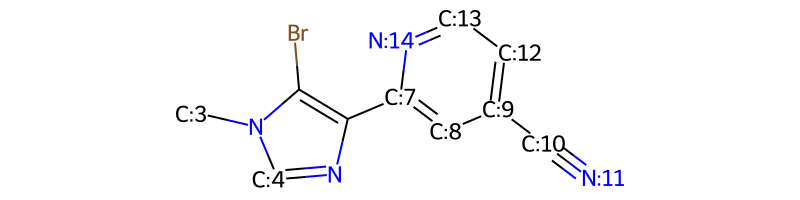

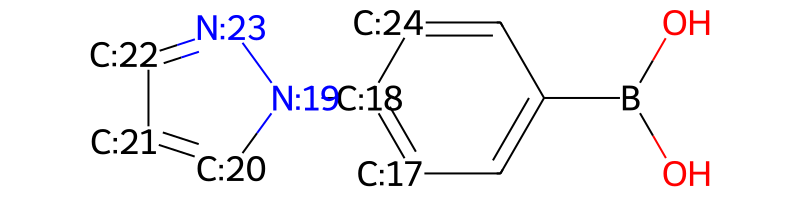

In [5]:
from utils import apply_template, visualize_mols

# Apply the extracted template to the product above.
prod_1 = rxn_example.split('>>')[1]
pred_reactants = apply_template(tplt_example, prod_1)

# This is the result of applying the template.
display(pred_reactants[0])
display(pred_reactants[1])

### To see how reaction templates encode a general transformation, let's now try to apply this template to a different product.

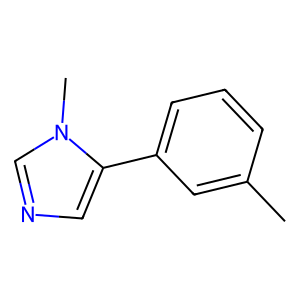

In [6]:
new_prod = 'CC1=CC(C2=CN=CN2C)=CC=C1'
# Let's try to break down this product, using the newly extracted reaction template.
visualize_mols(new_prod)

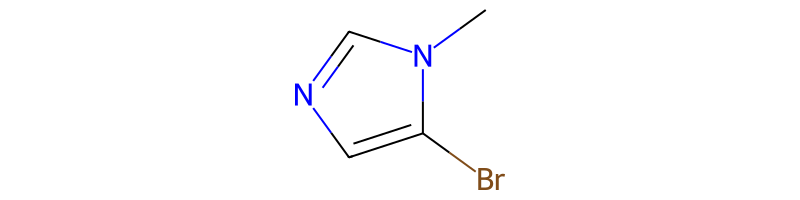

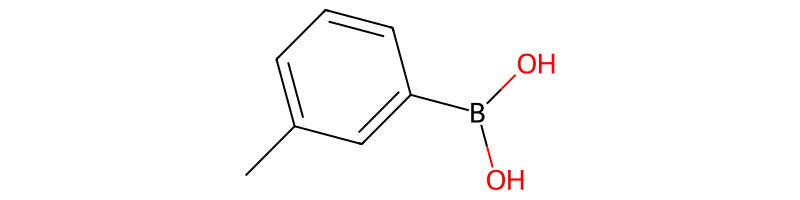

In [7]:
new_reactants = apply_template(tplt_example, new_prod)
display(new_reactants[0])
display(new_reactants[1])

## We have successfully encoded a Bromo Suzuki coupling!

As you can see, our reaction template can now be applied to any product, and the result of this operation are the reactants needed for this reaction to yield our product.
You can learn more about these templates [here](https://chimia.ch/chimia/article/view/2022_294/5301).

**What will happen if you try to apply the template to a product that makes no sense for this reaction type?**

# 2. Building a library of reaction templates

Let's now extract all possible reaction templates from our training data. With this, we can then train a model to select the best template for a given product!


### This takes around 10 minutes.

In [8]:
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

# Set this to False if you want to use the full dataset
SAMPLE = True

if SAMPLE:
    train_df = train_df.sample(frac=0.1)
    val_df = val_df.sample(frac=0.1)

train_df['tmplt'] = train_df['reactants>reagents>production'].progress_apply(extract_template)
val_df['tmplt'] = val_df['reactants>reagents>production'].progress_apply(extract_template)

template_library = (pd.concat([train_df['tmplt'], val_df['tmplt']])
                    .value_counts()
                    .index
                    .values
                   )

print(f'We have {len(template_library)} different templates!')

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

We have 2612 different templates!


In [9]:
# Now assign a class number to each entry in the dataset
import numpy as np

train_df['rxn_class'] = train_df['tmplt'].progress_apply(lambda x: np.where(template_library==x)[0][0])
val_df['rxn_class'] = val_df['tmplt'].progress_apply(lambda x: np.where(template_library==x)[0][0])

  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

# 3. Training a ML model to do retrosynthesis.

We have over 11k templates, and for a given product we need to decide which one is the best. The best type of models for this type of task are classification models, and you've learnt a few of them at the beggining of the course!

In this case, instead of predicting whether a molecule is toxic (2 classes), we will predict what template to use to make the molecule (>11k classes).

**As you may recall, we need to get a representation of our molecule that makes it easy for models to read it. Here, let's use Morgan Fingerprints.**

import `mol_smi_to_count_fp` from utils.py

In [10]:
from utils import mol_smi_to_count_fp

print('Getting FPs for training data')
train_fps = train_df['reactants>reagents>production'].progress_apply(lambda x: x.split('>>')[1]).progress_apply(mol_smi_to_count_fp)

print('Getting FPs for validation data')
val_fps = val_df['reactants>reagents>production'].progress_apply(lambda x: x.split('>>')[1]).progress_apply(mol_smi_to_count_fp)

print('Getting FPs for test data')
test_fps = test_df['reactants>reagents>production'].progress_apply(lambda x: x.split('>>')[1]).progress_apply(mol_smi_to_count_fp)

Getting FPs for training data


  0%|          | 0/4001 [00:00<?, ?it/s]

  0%|          | 0/4001 [00:00<?, ?it/s]

Getting FPs for validation data


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Getting FPs for test data


  0%|          | 0/5007 [00:00<?, ?it/s]

  0%|          | 0/5007 [00:00<?, ?it/s]

# Now we can try to use ML to tackle the retrosynthesis challenge!
### For this problem, classification models are quite appropriate, as we have a lot of classes and no idea how to assign them!

In [11]:
train_fps_dense = np.asarray(np.concatenate([v.todense() for v in train_fps.values]))
val_fps_dense = np.asarray(np.concatenate([v.todense() for v in val_fps.values]))

In [12]:
# Let's define a very simple random forest classifier
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    random_state=0,
    n_jobs=20,
    verbose=1
)

rf_clf.fit(train_fps_dense, train_df['rxn_class'])

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   14.1s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:   25.0s finished


RandomForestClassifier(max_depth=15, n_estimators=300, n_jobs=20,
                       random_state=0, verbose=1)

### Testing the model

There are two ways to test our model:
- Accuracy of template prediction
- Accuracy of precursor prediction

As you will see, they can differ! **Why?**

In [13]:
# Let's see validation accuracy on template prediction

val_preds = rf_clf.predict(val_fps_dense)
val_acc = (val_preds == val_df['rxn_class']).mean()

print(f'Validation accuracy in template prediction: {val_acc*100:.3f}%')

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.7s


Validation accuracy in template prediction: 11.600%


[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    1.3s finished


In [14]:
from rdkit import Chem

# Now, accuracy on precursor prediction
val_df['pred_tmplt_rfclf'] = template_library[val_preds]

# Apply the predicted template to the product

def get_precs_template(tmplt, prod):
    pred = apply_template(
        tmplt,
        prod
    )
    if pred:
        prods = [Chem.MolToSmiles(mol) for mol in pred]
        final = ".".join(prods)
        return final
    else:
        return 'Invalid template'


val_df['pred_prec'] = val_df.apply(
    lambda x: get_precs_template(
        x['pred_tmplt_rfclf'],
        x['reactants>reagents>production'].split('>>')[1]
    ),
    axis=1
)

from utils import canonicalize_smiles

# Compare the resulting reactants
val_df['prec_true'] = val_df['reactants>reagents>production'].apply(lambda x: canonicalize_smiles(x.split('>>')[0]))
val_df['pred_prec'] = val_df['pred_prec'].apply(canonicalize_smiles)


prec_acc = (val_df['pred_prec'] == val_df['prec_true']).mean()
print(f'Precursor prediction accuracy is {prec_acc*100:.3f}%')

Precursor prediction accuracy is 17.000%


In [15]:
# Pretty low, but why?

print(f'Template is invalid for {(val_df["pred_prec"]!="").sum()} products (out of {val_df.shape[0]}).')

# Let's see accuracy when template is valid
val_df_valid_preds = val_df[val_df['pred_prec']!='']

prec_acc_valid_preds = (val_df_valid_preds['pred_prec'] == val_df_valid_preds['prec_true']).mean()
print(f'Precursor prediction accuracy is {prec_acc_valid_preds*100:.3f}% (if we ignore invalid templates)')

Template is invalid for 179 products (out of 500).
Precursor prediction accuracy is 47.486% (if we ignore invalid templates)


# How to fix these issues?

- Our current model predicts only one class. One way to mitigate this is to predict multiple classes, and return the prediction from the first valid template.

- Train a better model.

## The best models achieve over 55% accuracy on this dataset (see [the leaderboard](https://paperswithcode.com/sota/single-step-retrosynthesis-on-uspto-50k)). There's still a lot to improve on this simple model, try some of the things you've learnt during the course!
---

# 4. Let's now apply our model to make some molecule of your interest

Using 79-th template.


To make this molecule


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.1s finished


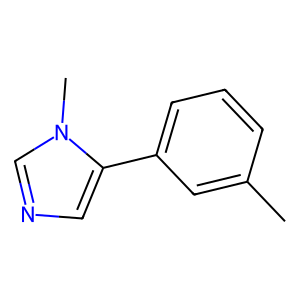

The RF model predicts these reactants:


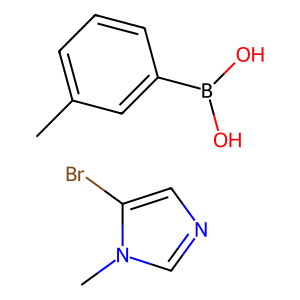

In [16]:
def predict_precursors(product):

    fp = mol_smi_to_count_fp(product).todense()
    logits = rf_clf.predict_proba(np.asarray(fp))

    sorted_templts = np.argsort(logits)[0][::-1]
    for i, t in enumerate(sorted_templts):
        template = template_library[t]
        try:
            prec = get_precs_template(template, product)
        except:
            continue
        if prec != 'Invalid template':
            print(f'Using {i}-th template.\n\n')
            print('To make this molecule')
            visualize_mols(product)
            print('The RF model predicts these reactants:')
            visualize_mols(prec)
            return prec


reacts = predict_precursors('CC1=CC(C2=CN=CN2C)=CC=C1')

### More resources

If you would like to learn more about data-driven retrosynthesis, we recommend the following resources:

- [Template-based single-step retrosynthesis](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/chem.201605499)
- [Multi-step retrosynthesis](https://www.nature.com/articles/nature25978)
